In [1]:
cd ..

/Users/David/CS6140-MatchingPursuit


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils.dataset_utils import *
from utils.dictionary_generation import *
from utils.matching_pursuit import *

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact, interactive, fixed, interact_manual, widgets


In [4]:
num_frames = 100

images = loadVideo("dataset/2011_09_26", num_frames)

In [5]:
print("Num images: ", len(images))
print("Image size: ", np.shape(images[0]))

Num images:  100
Image size:  (512, 1392)


In [6]:
images = cropImages(images)

In [7]:
def f(x):
    plt.imshow(images[x], cmap="Greys_r")
    plt.axis("off")
interact(f, x=widgets.IntSlider(min=0,max=num_frames-1,step=1,value=10))

interactive(children=(IntSlider(value=10, description='x', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [74]:
patch_size = 12
num_samples = 2000
num_features = 25

PCA_features = generatePCADictionary(images, patch_size, num_samples, num_features)
KMeans_features = generateKMeansDictionary(images, patch_size, num_samples, num_features)
OPT_features = generateOptSparseDictionary(images, patch_size, num_samples, num_features)
# plotDictionary(KMeans_features, '')
# generateDictionaryPlots(images, patch_size=24, num_samples=500, num_features=[25], cols=5, s=1)

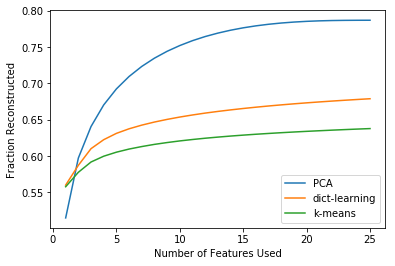

In [76]:
def plotDictSize_vs_Reconstruction(images, all_features, names):
    results = []
    num_samples = 1000
    num_features, patch_size,_ = all_features[0].shape
    video_patches, _ = generateVideoPatches(patch_size, images)
    samples = samplePatches(num_samples, video_patches)
    samples = samples.reshape(num_samples, patch_size**2)-0.5
    samples_norm = np.linalg.norm(samples, axis=1)
    
#     plt.figure()
    for c, features in enumerate(all_features):
        features = features.reshape((num_features, patch_size**2))
        #features mat is num_samples by num_features by patch_size^2
        features_mat = np.tile(features, (num_samples,1, 1))
        results = np.zeros((num_features,2))
        residual_samples = np.copy(samples)
        recon_samples = np.zeros_like(samples)
        for i in range(num_features):
            ## w is num_samples by num features
            w = np.matmul(residual_samples, features.T)
            sort_order = np.argsort(np.abs(w),axis=1)[:,-1:]
            w_sel = w[np.arange(num_samples)[:, np.newaxis], sort_order]
            f_sel = features_mat[np.arange(num_samples)[:, np.newaxis], sort_order]

            delta = np.sum(np.multiply(w_sel[:,:, None], f_sel),axis=1)
            recon_samples += delta
            residual_samples -= delta
            avg_recon_error = np.mean((samples_norm - np.linalg.norm(samples - recon_samples,axis=1))/samples_norm)
            results[i] = (i+1, avg_recon_error)
      
        plt.plot(results[:,0], results[:,1])
    plt.legend(names)
    plt.xlabel("Number of Features Used")
    plt.ylabel("Fraction Reconstructed")

plotDictSize_vs_Reconstruction(images, [PCA_features, OPT_features, KMeans_features], ["PCA", "dict-learning", "k-means"])

In [136]:
%matplotlib inline
k = 500

# S_code = greedyMatchingPursuit(images[0], features, k, True)
S_code = convolutionalMatchingPursuit(images[0], features, k, True)

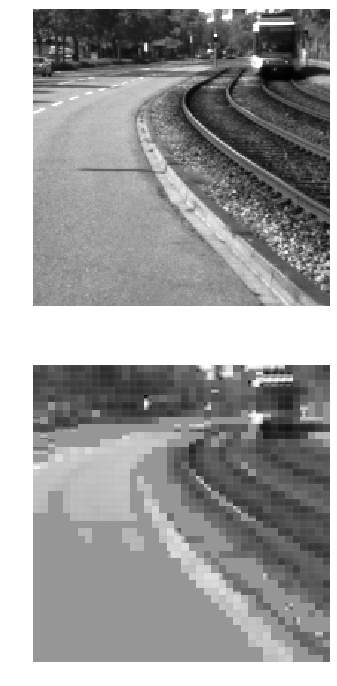

In [31]:
recon_image = generateReconImage(S_code, images[0], features)

#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(18,12))
ax1.imshow(images[0], cmap="Greys_r")
ax1.axis("off")

ax2.imshow(recon_image, cmap="Greys_r",vmin=0, vmax=1)
ax2.axis("off")

plt.show()